In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
df = pd.read_csv(r"exoplanet_catalogue.csv")

#------------------------------
# Earth-like classification rule
# -------------------------------
def is_earth_like(row):
    return (
        0.5 / 317.906 <= row["mass"] <= 5.0 / 317.906 and            
        2.4<= row["mass"] /((row['radius'])**3)<= 6.65 and            # Citation : Zeng, L., Sasselov, D. D., & Jacobsen, S. B. (2016). “Mass–radius relation for rocky planets based on PREM.” The Astrophysical Journal, 819(2), 127.
        0.0729 <= row["radius"] <= 0.137                                       # Citation : Zeng et al. (2016). Planet Radius Gap. and arXiv: 1407.4457 [astro-ph.EP]
        # 0.95 <= row["semi_major_axis"] <= 1.37 and                                # Cite : https://doi.org/10.1006/icar.1993.1010.
        # (0.0713 <= row["star_mass"] <= 0.107 or                                    # Citation : Scalo et al. (2007) – M-dwarfs and Earth-likeness
        # 0.8 <= row["star_radius"] <= 1.2) and                                      # Citation : Kaltenegger & Traub (2009) focus on planets around F, G, K stars , HabCat (Habitable Catalog by Turnbull & Tarter, 2003) uses a similar logic for identifying candidate stars.
        # 4800 <= row["star_teff"] <= 6300                                          # Citation: Kaltenegger & Traub (2009)
    )

df["earth_like"] = df.apply(is_earth_like, axis=1)

# -------------------------------
# Select features and labels
# -------------------------------
features = ["mass", "radius", "orbital_period", "semi_major_axis",
            "star_mass", "star_radius", "star_teff"]
#print(df['earth_like'])
count_true = np.count_nonzero(df['earth_like'])
print(count_true)
earth_like_planets = df[df['earth_like']]
len(df)
percentage = (count_true/len(df))*100
print(percentage)
#print(earth_like_planets)

88
1.187904967602592


In [36]:
# while True: 
#     # Get a random index from the DataFrame
#     random_index = np.random.choice(df.index)

#     # Select the random row
#     random_row = df.loc[random_index]

#     if random_row['earth_like'] == True:
#         print(f"index {random_index} is Earth-like: {random_row['earth_like']}")
#         # Print the specified features from the random row
#         print(f"Mass: {random_row['mass']}")
#         print(f"Radius: {random_row['radius']}")
#         print(f"Semi-major Axis: {random_row['semi_major_axis']}")
#         print(f"Star Mass: {random_row['star_mass']}")
#         print(f"Star Radius: {random_row['star_radius']}")
#         print(f"Star Effective Temperature: {random_row['star_teff']}")

#         break

In [ ]:
def compute_esi(mass, radius, star_temp, star_radius, semi_major_axis, w_radius=0.57, w_density=1.07, w_Escape_velocity= 0.7, w_temp = 5.58):
    # Conversion factors
    MJ_TO_ME = 1.899e+27     # Jupiter mass to Earth mass
    RJ_TO_RE = 7.149e+7     # Jupiter radius to Earth radius
    G =6.67*10**(-11)

    # Convert to SI units
    mass_e = mass * MJ_TO_ME
    radius_e = radius * RJ_TO_RE

    # Estimate density in SI units:
    density_e = mass_e /((4/3)*np.pi*(radius_e ** 3))
    #Escape velocity
    Escape_velocity = np.sqrt(2*mass_e*G/radius_e)

    # Exoplanet Equilibrium tempertaure calculations
    T_eq = star_temp  * np.sqrt(star_radius / (2 * semi_major_axis)) * (1-0.3) ** 0.25

    # print(f"mass_e: {mass_e}")
    # print(f"radius_e: {radius_e}")
    # print(f"density_e: {density_e}")
    # print(f"Escape_velocity: {Escape_velocity}")

    # Normalized ESI formula (interior version)
    r_comp = (1 - abs((radius_e - 6.378e+6) / (radius_e + 6.378e+6))) ** w_radius
    d_comp = (1 - abs((density_e - 5532) / (density_e + 5532))) ** w_density
    v_comp = (1 - abs((Escape_velocity - 11186 ) / (Escape_velocity + 11186 ))) ** w_Escape_velocity
    t_comp = (1 - abs((T_eq - 288) / (T_eq + 288))) ** w_temp
    # Calculate ESI
    esi = (r_comp * d_comp*v_comp) ** (1 / (w_radius + w_density + w_Escape_velocity))
    return esi

compute_esi(0.00314558, 0.0892147)

mass_e: 5.97345642e+24
radius_e: 6377958.903
density_e: 5496.572248141412
Escape_velocity: 11177.634549471755


0.9988024216524054

In [45]:
compute_esi(1,1)

mass_e: 1.899e+27
radius_e: 71490000.0
density_e: 1240.7962270763508
Escape_velocity: 59527.51438223392


0.2667923935316452

In [46]:
df['ESI'] = compute_esi(df['mass'],df['radius'])


mass_e: 0       1.090596e+28
1       6.266700e+25
2       1.873553e+28
3       3.062783e+28
4       2.105478e+28
            ...     
7403    3.608100e+28
7404    9.495000e+28
7405    1.158390e+29
7406    4.367700e+28
7407    4.937400e+28
Name: mass, Length: 7408, dtype: float64
radius_e: 0       82356480.0
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
7403    31455600.0
7404    20875080.0
7405    70060200.0
7406    48613200.0
7407    35030100.0
Name: radius, Length: 7408, dtype: float64
density_e: 0       4.661029e+03
1                NaN
2                NaN
3                NaN
4                NaN
            ...     
7403    2.767554e+05
7404    2.491850e+06
7405    8.041778e+04
7406    9.076148e+04
7407    2.742114e+05
Length: 7408, dtype: float64
Escape_velocity: 0       132910.997444
1                 NaN
2                 NaN
3                 NaN
4                 NaN
            ...      
7403    391172.405614
7404    778953.1

In [47]:
print(f"max of ESI: {df['ESI'].max()}")

max of ESI: 0.9966880967167873


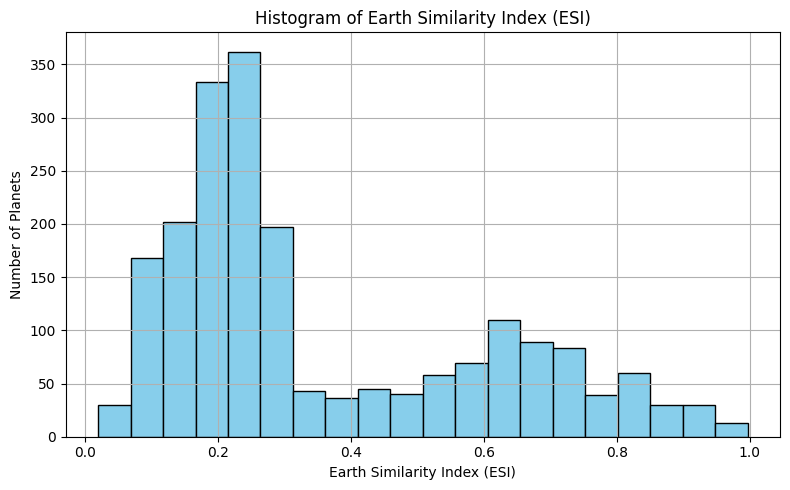

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(df["ESI"], bins=20, color="skyblue", edgecolor="black")
plt.xlabel("Earth Similarity Index (ESI)")
plt.ylabel("Number of Planets")
plt.title("Histogram of Earth Similarity Index (ESI)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [55]:
eldf = df[df['ESI']>0.8].copy()

print(len(eldf))

133


In [ ]:
# Constants
ALBEDO = 0.3
SOLAR_RADIUS_M = 6.96e8  # in meters
AU_M = 1.496e11  # in meters


while True: 
    # Get a random index from the DataFrame
    random_index = np.random.choice(df.index)

    # Select the random row
    random_row = df.loc[random_index]

    if random_row['ESI'] > 0.9:
        print(f"index {random_index} is Earth-like: {random_row['ESI']}")
        # Print the specified features from the random row
        print(f"Mass: {random_row['mass']}")
        print(f"Radius: {random_row['radius']}")
        print(f"Semi-major Axis: {random_row['semi_major_axis']}")
        print(f"Star Mass: {random_row['star_mass']}")
        print(f"Star Radius: {random_row['star_radius']}")
        print(f"Star Effective Temperature: {random_row['star_teff']}")

        # Convert R and a to meters
        R = random_row['star_radius'] * SOLAR_RADIUS_M
        a_m = random_row['semi_major_axis'] * AU_M

        # Compute equilibrium temperature
        T_eq = random_row['star_teff'] * np.sqrt(R / (2 * a_m)) * (1 - ALBEDO) ** 0.25
        print(f"Equilibrium Temperature: {T_eq:.2f} K")

        break

index 6564 is Earth-like: 0.9057770081217893
Mass: 0.0069
Radius: 0.1169
Semi-major Axis: 0.0204
Star Mass: 0.99
Star Radius: 0.94
Star Effective Temperature: 5752.0
Equilibrium Temperature: 1722.53 K


In [73]:
print(len(df))

df_drop = df.dropna(subset=['mass','radius','star_teff','semi_major_axis','star_radius'])
print(len(df_drop))

7408
1455


In [68]:
T_eq = 5772 * np.sqrt(6.378e+6 / (2 * 1.496e+11)) * (1 - ALBEDO) ** 0.25

print(T_eq)

24.375991809138217


ESI will be a broad classification to narrow down on Earth like planets

Then we calculate the $T_{eq}$. We assume no greenhouse effect, and similar atmospheric pressure to Earth, this leads to a simliar freezing and boiling point of water. Using $T_{eq}$ we again constain our Earth like planets.